# Setup

In [ ]:
# from google.colab import drive
# import shutil

# drive.mount('/content/drive')

In [ ]:
%%capture
try:
    #import google.colab # type: ignore
    #from google.colab import output
    %pip install transformer-lens
except:
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

In [ ]:
from transformer_lens import HookedTransformer

from torch import nn, Tensor
from jaxtyping import Float, Int
from typing import Optional, Callable, Union, List, Tuple

from datasets import load_dataset
from rich import print as rprint  # printing highlights in data samples
import pickle
from google.colab import files

import torch
import os

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

Using device: cuda


# change input params here

In [ ]:
model_name = "tiny-stories-1L-21M"
model_name_2 = "tiny-stories-2L-33M"
short_model_name = 'ts_1L_21M'
short_model_name_2 = 'ts_2L_33M'
layer_name = "blocks.0.hook_mlp_out"
layer_name_2 = "blocks.0.hook_mlp_out"

save_data_fn = 'batch_tokens_anySamps_v1.pkl'
Wdec_filename = 'Wdec_' + short_model_name + '_LLM.pkl'
acts_save_path = 'LLMacts_' + short_model_name + '_anySamps_v1.pkl'
Wdec_filename_2 = 'Wdec_' + short_model_name_2 + '_LLM.pkl'
acts_save_path_2 = 'LLMacts_' + short_model_name_2 + '_anySamps_v1.pkl'

# load models

In [ ]:
model = HookedTransformer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model tiny-stories-1L-21M into HookedTransformer


In [ ]:
model_2 = HookedTransformer.from_pretrained(model_name_2)

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/323M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/722 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Loaded pretrained model tiny-stories-2L-33M into HookedTransformer


## load weights

In [ ]:
from transformers import AutoModelForCausalLM

model_hf = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-1Layer-21M")
mlp_weights = model_hf.transformer.h[0].mlp.c_proj.weight
mlp_weights.shape

torch.Size([1024, 4096])

In [ ]:
model_2_hf = AutoModelForCausalLM.from_pretrained("roneneldan/TinyStories-2Layers-33M")
mlp_weights_2 = model_2_hf.transformer.h[0].mlp.c_proj.weight
mlp_weights_2.shape

torch.Size([1024, 4096])

In [ ]:
model_hf.transformer.h[0].mlp

GPTNeoMLP(
  (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
  (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
  (act): NewGELUActivation()
  (dropout): Dropout(p=0.0, inplace=False)
)

In [ ]:
mlp_weights = mlp_weights.detach().numpy()
mlp_weights_2 = mlp_weights_2.detach().numpy()

# load dataset

## get data

Need load model tokenizer before obtain dataset

In [ ]:
from transformer_lens.utils import tokenize_and_concatenate

dataset = load_dataset("roneneldan/TinyStories", streaming=False)
test_dataset = dataset['validation']

token_dataset = tokenize_and_concatenate(
    dataset = test_dataset,
    tokenizer = model.tokenizer, # type: ignore
    streaming=True,
    max_length=128,
    add_bos_token=False,
)

README.md:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

(…)-00000-of-00004-2d5a1467fff1081b.parquet:   0%|          | 0.00/249M [00:00<?, ?B/s]

(…)-00001-of-00004-5852b56a2bd28fd9.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00002-of-00004-a26307300439e943.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

(…)-00003-of-00004-d243063613e5a057.parquet:   0%|          | 0.00/248M [00:00<?, ?B/s]

(…)-00000-of-00001-869c898b519ad725.parquet:   0%|          | 0.00/9.99M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/21990 [00:00<?, ? examples/s]

Map:   0%|          | 0/21990 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (10434 > 2048). Running this sequence through the model will result in indexing errors


In [ ]:
token_dataset.shape

(37054, 1)

In [ ]:
batch_tokens = token_dataset[:500]["tokens"]
batch_tokens.shape

torch.Size([500, 128])

## save selected data

In [ ]:
with open(save_data_fn, 'wb') as f:
    pickle.dump(batch_tokens, f)

# source_path = f'/path/to/your/file/{file_name}'
source_path = save_data_fn
# dest_folder = ''
destination_path = f'/content/drive/MyDrive/{save_data_fn}'

shutil.copy(source_path, destination_path) # Copy the file

## load selected data

In [ ]:
# check if saved
file_path = '/content/drive/MyDrive/' + save_data_fn
with open(file_path, 'rb') as f:
    batch_tokens = pickle.load(f)

In [ ]:
batch_tokens.shape

torch.Size([500, 128])

# get LLM actvs

## get

In [ ]:
h_store = torch.zeros((batch_tokens.shape[0], batch_tokens.shape[1], model.cfg.d_model), device=model.cfg.device)
h_store.shape

torch.Size([500, 128, 1024])

In [ ]:
def store_h_hook(
    pattern: Float[Tensor, "batch seqlen d_model"],
    hook
):
    h_store[:] = pattern  # this works b/c changes values, not replaces entire thing

In [ ]:
model.run_with_hooks(
    batch_tokens,
    return_type = None,
    fwd_hooks=[
        (layer_name, store_h_hook),
    ]
)

In [ ]:
h_store_2 = torch.zeros((batch_tokens.shape[0], batch_tokens.shape[1], model_2.cfg.d_model), device=model_2.cfg.device)
def store_h_hook_2(
    pattern: Float[Tensor, "batch seqlen d_model"],
    hook
):
    h_store_2[:] = pattern  # this works b/c changes values, not replaces entire thing

model_2.run_with_hooks(
    batch_tokens,
    return_type = None,
    fwd_hooks=[
        (layer_name, store_h_hook_2),
    ]
)

## save actvs

In [ ]:
with open(acts_save_path, 'wb') as f:
    pickle.dump(h_store, f)

# source_path = f'/path/to/your/file/{file_name}'
source_path = acts_save_path
# dest_folder = ''
destination_path = f'/content/drive/MyDrive/{acts_save_path}'

shutil.copy(source_path, destination_path) # Copy the file

NameError: name 'shutil' is not defined

In [ ]:
with open(acts_save_path_2, 'wb') as f:
    pickle.dump(h_store_2, f)

# source_path = f'/path/to/your/file/{file_name}'
source_path = acts_save_path_2
# dest_folder = ''
destination_path = f'/content/drive/MyDrive/{acts_save_path_2}'

shutil.copy(source_path, destination_path) # Copy the file

In [ ]:
# check if saved
file_path = '/content/drive/MyDrive/' + acts_save_path
with open(file_path, 'rb') as f:
    h_store = pickle.load(f)

## reshape for corr

In [ ]:
first_dim_reshaped = h_store.shape[0] * h_store.shape[1]
reshaped_activations_A = h_store.reshape(first_dim_reshaped, h_store.shape[-1]).cpu()
reshaped_activations_B = h_store_2.reshape(first_dim_reshaped, h_store_2.shape[-1]).cpu()

In [ ]:
reshaped_activations_A.shape

torch.Size([64000, 1024])

# neuron corr by actvs

## fns

In [ ]:
def find_all_highest_correlations(reshaped_activations_A, reshaped_activations_B):
    # Ensure tensors are on GPU
    if torch.cuda.is_available():
        reshaped_activations_A = reshaped_activations_A.to('cuda')
        reshaped_activations_B = reshaped_activations_B.to('cuda')

    # Normalize columns of A
    mean_A = reshaped_activations_A.mean(dim=0, keepdim=True)
    std_A = reshaped_activations_A.std(dim=0, keepdim=True)
    normalized_A = (reshaped_activations_A - mean_A) / (std_A + 1e-8)  # Avoid division by zero

    # Normalize columns of B
    mean_B = reshaped_activations_B.mean(dim=0, keepdim=True)
    std_B = reshaped_activations_B.std(dim=0, keepdim=True)
    normalized_B = (reshaped_activations_B - mean_B) / (std_B + 1e-8)  # Avoid division by zero

    # Compute correlation matrix
    correlation_matrix = torch.matmul(normalized_A.t(), normalized_B) / normalized_A.shape[0]

    # Handle NaNs by setting them to -inf
    correlation_matrix = torch.where(torch.isnan(correlation_matrix), torch.tensor(float('-inf')).to(correlation_matrix.device), correlation_matrix)

    # Get the highest correlation indices and values
    highest_correlations_values, highest_correlations_indices = correlation_matrix.max(dim=0)

    # Move results back to CPU
    highest_correlations_indices = highest_correlations_indices.cpu().detach().numpy()
    highest_correlations_values = highest_correlations_values.cpu().detach().numpy()

    return highest_correlations_indices, highest_correlations_values

## test

In [ ]:
highest_correlations_indices, highest_correlations_values = find_all_highest_correlations(reshaped_activations_A, reshaped_activations_B)
print(f'Highest correlations indices: {highest_correlations_indices}')
print(f'Highest correlations values: {highest_correlations_values}')

Highest correlations indices: [401 956 159 ... 764 202 972]
Highest correlations values: [0.17075741 0.1350496  0.10393947 ... 0.13407917 0.17686975 0.10175729]


In [ ]:
len(highest_correlations_indices)

1024

In [ ]:
len(list(set(highest_correlations_indices)))

409

In [ ]:
sum(highest_correlations_values) / len(highest_correlations_values)

0.15356187740690075

## compare to SAE corrs

In [ ]:
import pickle
# with open('highest_corr_inds_1L_2L_MLP0_16k_30k_relu.pkl', 'rb') as f:
#     highest_correlations_indices_saes = pickle.load(f)
with open('highest_corr_vals_1L_2L_MLP0_16k_30k_relu.pkl', 'rb') as f:
    highest_correlations_values_saes = pickle.load(f)

In [ ]:
sum(highest_correlations_values_saes) / len(highest_correlations_values_saes)

0.6283994152836385

# get rand

In [ ]:
def score_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    i = 0
    # for i in range(num_runs):
    while i < num_runs:
        try:
            rand_modA_feats = np.random.choice(range(weight_matrix_np.shape[0]), size=num_feats, replace=False).tolist()
            rand_modB_feats = np.random.choice(range(weight_matrix_2.shape[0]), size=num_feats, replace=False).tolist()

            if shapereq_bool:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
            else:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
            all_rand_scores.append(score)
            i += 1
        except:
            continue
    return sum(all_rand_scores) / len(all_rand_scores)

In [ ]:
import random
def shuffle_rand(num_runs, weight_matrix_np, weight_matrix_2, num_feats, sim_fn, shapereq_bool):
    all_rand_scores = []
    for i in range(num_runs):
        row_idxs = list(range(num_feats))
        random.shuffle(row_idxs)
        if shapereq_bool:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs], "nd")
        else:
            score = sim_fn(weight_matrix_np, weight_matrix_2[row_idxs])
        all_rand_scores.append(score)
    # return sum(all_rand_scores) / len(all_rand_scores)
    return all_rand_scores

In [ ]:
def score_rand_corr(num_runs, weight_matrix_np, weight_matrix_2, num_feats, highest_correlations_indices_AB, sim_fn, shapereq_bool):
    all_rand_scores = []
    i = 0
    # for i in range(num_runs):
    while i < num_runs:
        try:
            rand_modB_feats = np.random.choice(range(weight_matrix_2.shape[0]), size=num_feats, replace=False).tolist()
            rand_modA_feats = [highest_correlations_indices_AB[index] for index in rand_modB_feats]

            if shapereq_bool:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats], "nd")
            else:
                score = sim_fn(weight_matrix_np[rand_modA_feats], weight_matrix_2[rand_modB_feats])
            all_rand_scores.append(score)
            i += 1
        except:
            continue
    # print(sum(all_rand_scores) / len(all_rand_scores))
    # plt.hist(all_rand_scores)
    # plt.show()
    return all_rand_scores

# interpret

## fns

In [ ]:
def highest_activating_tokens(
    feature_acts,
    feature_idx: int,
    k: int = 10,  # num batch_seq samples
    batch_tokens=None
): # -> Tuple[Int[Tensor, "k 2"], Float[Tensor, "k"]]:
    '''
    Returns the indices & values for the highest-activating tokens in the given batch of data.
    '''
    batch_size, seq_len = batch_tokens.shape

    # Get the top k largest activations for only targeted feature
    # need to flatten (batch,seq) into batch*seq first because it's ANY batch_seq, even if in same batch or same pos
    flattened_feature_acts = feature_acts[:, :, feature_idx].reshape(-1)

    top_acts_values, top_acts_indices = flattened_feature_acts.topk(k)
    # top_acts_values should be 1D
    # top_acts_indices should be also be 1D. Now, turn it back to 2D
    # Convert the indices into (batch, seq) indices
    top_acts_batch = top_acts_indices // seq_len
    top_acts_seq = top_acts_indices % seq_len

    return torch.stack([top_acts_batch, top_acts_seq], dim=-1), top_acts_values

In [ ]:
def store_top_toks(top_acts_indices, top_acts_values, batch_tokens):
    feat_samps = []
    for (batch_idx, seq_idx), value in zip(top_acts_indices, top_acts_values):
        new_str_token = model.tokenizer.decode(batch_tokens[batch_idx, seq_idx]).replace("\n", "\\n").replace("<|BOS|>", "|BOS|")
        feat_samps.append(new_str_token)
    return feat_samps

In [ ]:
def find_indices_with_keyword(fList, keyword):
    """
    Find all indices of fList which contain the keyword in the string at those indices.

    Args:
    fList (list of str): List of strings to search within.
    keyword (str): Keyword to search for within the strings of fList.

    Returns:
    list of int: List of indices where the keyword is found within the strings of fList.
    """
    index_list = []
    for index, split_list in enumerate(fList):
        no_space_list = [i.replace(' ', '').lower() for i in split_list]
        if keyword in no_space_list:
            index_list.append(index)
    return index_list

## run

In [ ]:
# store feature : lst of top strs
fList_model_B_top5 = []
samp_m = 5

for feature_idx in range(h_store_2.shape[-1]):
    if feature_idx % 500 == 0:
        print('Feature: ', feature_idx)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(h_store_2, feature_idx, samp_m, batch_tokens=batch_tokens)
    fList_model_B_top5.append(store_top_toks(ds_top_acts_indices, ds_top_acts_values, batch_tokens) )

Feature:  0
Feature:  500
Feature:  1000


In [ ]:
fList_model_B_top5

[[' upon', ' upon', ' upon', ' upon', ' upon'],
 [' so', ' f', ' tears', ' so', ' too'],
 [' is', ' is', ' is', ' is', ' is'],
 [' there', ' things', ' in', ' in', ' going'],
 [' first', ' say', ' first', ' first', ' last'],
 [' what', ' pulled', ' thanked', ' thanks', ' cheer'],
 [' had', ' at', ' inside', ' went', ' 20'],
 [' first', ' up', ' friends', ' up', ' in'],
 [' to', ' many', ' all', ' all', ' of'],
 [' as', ' upon', ' as', ' upon', ' upon'],
 [' couldn', ' then', ' didn', ' didn', ' didn'],
 ['...', ' fascinated', ' amazed', ' on', ' time'],
 ['ave', ' give', ' cheer', ' off', ' give'],
 [' look', ' looking', ' look', ' at', ' look'],
 [' l', ' l', ' There', ' l', ' w'],
 [' high', ' be', ' back', ' back', ' happy'],
 [' give', ' out', ' give', ' gave', ' cried'],
 [' over', ' when', ' with', ' listen', ' of'],
 [' no', ' forget', ' forget', ' forgot', ' forgot'],
 ['After', 'After', 'After', 'After', 'After'],
 [' get', ' wanted', ' crying', ' happy', ' want'],
 [' did', '

(array([2.5000e+01, 3.7800e+02, 2.7400e+03, 1.3580e+04, 2.8023e+04,
        1.4700e+04, 3.5580e+03, 9.0400e+02, 8.4000e+01, 8.0000e+00]),
 array([-1.34446263, -1.04638147, -0.74830031, -0.45021918, -0.15213804,
         0.14594311,  0.44402426,  0.74210542,  1.04018652,  1.33826768,
         1.63634884]),
 <BarContainer object of 10 artists>)

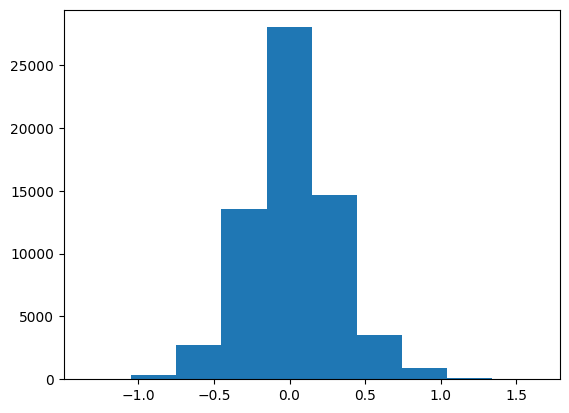

In [ ]:
from matplotlib import pyplot as plt
plt.hist(reshaped_activations_B[:, 0].detach().numpy())

In [ ]:
# store feature : lst of top strs
fList_model_B = []
samp_m = 5*16

for feature_idx in range(h_store_2.shape[-1]):
    if feature_idx % 500 == 0:
        print('Feature: ', feature_idx)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(h_store_2, feature_idx, samp_m, batch_tokens=batch_tokens)
    fList_model_B.append(store_top_toks(ds_top_acts_indices, ds_top_acts_values, batch_tokens) )

Feature:  0
Feature:  500
Feature:  1000


In [ ]:
fList_model_B

[[' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' kings',
  ' common',
  ' have',
  ' lesson',
  ' in',
  ' be',
  ' each',
  ' upon',
  ' express',
  ' upon',
  ' each',
  ' upon',
  ' upon',
  ' having',
  ' every',
  ' upon',
  ' every',
  ' upon',
  ' lives',
  ' upon',
  ' made',
  ' upon',
  ' upon',
  ' make',
  ' be',
  ' sh',
  ' each',
  ' time',
  ' time',
  ' upon',
  ' characters',
  ' make',
  ' time',
  ' or',
  ' upon',
  ' upon',
  ' builders',
  ' be',
  ' upon',
  ' upon',
  ' upon',
  ' owns',
  ' upon',
  ' upon',
  ' upon',
  ' upon',
  ' each',
  ' every',
  ' pieces',
  ' upon',
  ' upon',
  ' upon',
  ' groups',
  ' time',
  ' time',
  ' upon',
  ' teach',
  ' don',
  ' with',
  ' play',
  ' proper',
  ' make',
  ' time',
  ' upon',
  ' sixth',
  ' be',
  ' upon'],
 [' so',
  ' f',
  ' tears',
  ' so',
  ' too',
  ' so',
  ' f',
  ' so',
  ' so',
  ' on',
  ' didn',

In [ ]:
# store feature : lst of top strs
fList_model_B_top30 = []
samp_m = 30

for feature_idx in range(h_store_2.shape[-1]):
    if feature_idx % 500 == 0:
        print('Feature: ', feature_idx)
    ds_top_acts_indices, ds_top_acts_values = highest_activating_tokens(h_store_2, feature_idx, samp_m, batch_tokens=batch_tokens)
    fList_model_B_top30.append(store_top_toks(ds_top_acts_indices, ds_top_acts_values, batch_tokens) )

Feature:  0
Feature:  500
Feature:  1000


# svcca on rand corr subset

## fns

In [ ]:
import functools
import logging
from abc import ABC
from abc import abstractmethod
from dataclasses import dataclass
from dataclasses import field
from typing import Any
from typing import Callable
from typing import get_args
from typing import List
from typing import Literal
from typing import Optional
from typing import Protocol
from typing import Tuple
from typing import Union

import numpy as np
import numpy.typing as npt
import torch
from einops import rearrange
# from loguru import logger

log = logging.getLogger(__name__)


SHAPE_TYPE = Literal["nd", "ntd", "nchw"]

ND_SHAPE, NTD_SHAPE, NCHW_SHAPE = get_args(SHAPE_TYPE)[0], get_args(SHAPE_TYPE)[1], get_args(SHAPE_TYPE)[2]


class SimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float: ...


class RSMSimilarityFunction(Protocol):
    def __call__(  # noqa: E704
        self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE, n_jobs: int
    ) -> float: ...


@dataclass
class BaseSimilarityMeasure(ABC):
    larger_is_more_similar: bool
    is_symmetric: bool

    is_metric: bool | None = None
    invariant_to_affine: bool | None = None
    invariant_to_invertible_linear: bool | None = None
    invariant_to_ortho: bool | None = None
    invariant_to_permutation: bool | None = None
    invariant_to_isotropic_scaling: bool | None = None
    invariant_to_translation: bool | None = None
    name: str = field(init=False)

    def __post_init__(self):
        self.name = self.__class__.__name__

    @abstractmethod
    def __call__(self, *args: Any, **kwds: Any) -> Any:
        raise NotImplementedError


class FunctionalSimilarityMeasure(BaseSimilarityMeasure):
    @abstractmethod
    def __call__(self, output_a: torch.Tensor | npt.NDArray, output_b: torch.Tensor | npt.NDArray) -> float:
        raise NotImplementedError


@dataclass(kw_only=True)
class RepresentationalSimilarityMeasure(BaseSimilarityMeasure):
    sim_func: SimilarityFunction

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
    ) -> float:
        return self.sim_func(R, Rp, shape)


class RSMSimilarityMeasure(RepresentationalSimilarityMeasure):
    sim_func: RSMSimilarityFunction

    @staticmethod
    def estimate_good_number_of_jobs(R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray) -> int:
        # RSMs in are NxN (or DxD) so the number of jobs should roughly scale quadratically with increase in N (or D).
        # False! As long as sklearn-native metrics are used, they will use parallel implementations regardless of job
        # count. Each job would spawn their own threads, which leads to oversubscription of cores and thus slowdown.
        # This seems to be not fully correct (n_jobs=2 seems to actually use two cores), but using n_jobs=1 seems the
        # fastest.
        return 1

    def __call__(
        self,
        R: torch.Tensor | npt.NDArray,
        Rp: torch.Tensor | npt.NDArray,
        shape: SHAPE_TYPE,
        n_jobs: Optional[int] = None,
    ) -> float:
        if n_jobs is None:
            n_jobs = self.estimate_good_number_of_jobs(R, Rp)
        return self.sim_func(R, Rp, shape, n_jobs=n_jobs)


def to_numpy_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[npt.NDArray]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> npt.NDArray:
        return x if isinstance(x, np.ndarray) else x.numpy()

    return list(map(convert, args))


def to_torch_if_needed(*args: Union[torch.Tensor, npt.NDArray]) -> List[torch.Tensor]:
    def convert(x: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
        return x if isinstance(x, torch.Tensor) else torch.from_numpy(x)

    return list(map(convert, args))


def adjust_dimensionality(R: npt.NDArray, Rp: npt.NDArray, strategy="zero_pad") -> Tuple[npt.NDArray, npt.NDArray]:
    D = R.shape[1]
    Dp = Rp.shape[1]
    if strategy == "zero_pad":
        if D - Dp == 0:
            return R, Rp
        elif D - Dp > 0:
            return R, np.concatenate((Rp, np.zeros((Rp.shape[0], D - Dp))), axis=1)
        else:
            return np.concatenate((R, np.zeros((R.shape[0], Dp - D))), axis=1), Rp
    else:
        raise NotImplementedError()


def center_columns(R: npt.NDArray) -> npt.NDArray:
    return R - R.mean(axis=0)[None, :]


def normalize_matrix_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord="fro")


def normalize_row_norm(R: npt.NDArray) -> npt.NDArray:
    return R / np.linalg.norm(R, ord=2, axis=1, keepdims=True)


def standardize(R: npt.NDArray) -> npt.NDArray:
    return (R - R.mean(axis=0, keepdims=True)) / R.std(axis=0)


def double_center(x: npt.NDArray) -> npt.NDArray:
    return x - x.mean(axis=0, keepdims=True) - x.mean(axis=1, keepdims=True) + x.mean()


def align_spatial_dimensions(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Aligns spatial representations by resizing them to the smallest spatial dimension.
    Subsequent aligned spatial representations are flattened, with the spatial aligned representations
    moving into the *sample* dimension.
    """
    R_re, Rp_re = resize_wh_reps(R, Rp)
    R_re = rearrange(R_re, "n c h w -> (n h w) c")
    Rp_re = rearrange(Rp_re, "n c h w -> (n h w) c")
    if R_re.shape[0] > 5000:
        logger.info(f"Got {R_re.shape[0]} samples in N after flattening. Subsampling to reduce compute.")
        subsample = R_re.shape[0] // 5000
        R_re = R_re[::subsample]
        Rp_re = Rp_re[::subsample]

    return R_re, Rp_re


def average_pool_downsample(R, resize: bool, new_size: tuple[int, int]):
    if not resize:
        return R  # do nothing
    else:
        is_numpy = isinstance(R, np.ndarray)
        R_torch = torch.from_numpy(R) if is_numpy else R
        R_torch = torch.nn.functional.adaptive_avg_pool2d(R_torch, new_size)
        return R_torch.numpy() if is_numpy else R_torch


def resize_wh_reps(R: npt.NDArray, Rp: npt.NDArray) -> Tuple[npt.NDArray, npt.NDArray]:
    """
    Function for resizing spatial representations that are not the same size.
    Does through fourier transform and resizing.

    Args:
        R: numpy array of shape  [batch_size, height, width, num_channels]
        RP: numpy array of shape [batch_size, height, width, num_channels]

    Returns:
        fft_acts1: numpy array of shape [batch_size, (new) height, (new) width, num_channels]
        fft_acts2: numpy array of shape [batch_size, (new) height, (new) width, num_channels]

    """
    height1, width1 = R.shape[2], R.shape[3]
    height2, width2 = Rp.shape[2], Rp.shape[3]
    if height1 != height2 or width1 != width2:
        height = min(height1, height2)
        width = min(width1, width2)
        new_size = [height, width]
        resize = True
    else:
        height = height1
        width = width1
        new_size = None
        resize = False

    # resize and preprocess with fft
    avg_ds1 = average_pool_downsample(R, resize=resize, new_size=new_size)
    avg_ds2 = average_pool_downsample(Rp, resize=resize, new_size=new_size)
    return avg_ds1, avg_ds2


def fft_resize(images, resize=False, new_size=None):
    """Function for applying DFT and resizing.

    This function takes in an array of images, applies the 2-d fourier transform
    and resizes them according to new_size, keeping the frequencies that overlap
    between the two sizes.

    Args:
              images: a numpy array with shape
                      [batch_size, height, width, num_channels]
              resize: boolean, whether or not to resize
              new_size: a tuple (size, size), with height and width the same

    Returns:
              im_fft_downsampled: a numpy array with shape
                           [batch_size, (new) height, (new) width, num_channels]
    """
    assert len(images.shape) == 4, "expecting images to be" "[batch_size, height, width, num_channels]"
    if resize:
        # FFT --> remove high frequencies --> inverse FFT
        im_complex = images.astype("complex64")
        im_fft = np.fft.fft2(im_complex, axes=(1, 2))
        im_shifted = np.fft.fftshift(im_fft, axes=(1, 2))

        center_width = im_shifted.shape[2] // 2
        center_height = im_shifted.shape[1] // 2
        half_w = new_size[0] // 2
        half_h = new_size[1] // 2
        cropped_fft = im_shifted[
            :, center_height - half_h : center_height + half_h, center_width - half_w : center_width + half_w, :
        ]
        cropped_fft_shifted_back = np.fft.ifft2(cropped_fft, axes=(1, 2))
        return cropped_fft_shifted_back.real
    else:
        return images


class Pipeline:
    def __init__(
        self,
        preprocess_funcs: List[Callable[[npt.NDArray], npt.NDArray]],
        similarity_func: Callable[[npt.NDArray, npt.NDArray, SHAPE_TYPE], float],
    ) -> None:
        self.preprocess_funcs = preprocess_funcs
        self.similarity_func = similarity_func

    def __call__(self, R: npt.NDArray, Rp: npt.NDArray, shape: SHAPE_TYPE) -> float:
        try:
            for preprocess_func in self.preprocess_funcs:
                R = preprocess_func(R)
                Rp = preprocess_func(Rp)
            return self.similarity_func(R, Rp, shape)
        except ValueError as e:
            log.info(f"Pipeline failed: {e}")
            return np.nan

    def __str__(self) -> str:
        def func_name(func: Callable) -> str:
            return func.__name__ if not isinstance(func, functools.partial) else func.func.__name__

        def partial_keywords(func: Callable) -> str:
            if not isinstance(func, functools.partial):
                return ""
            else:
                return str(func.keywords)

        return (
            "Pipeline("
            + (
                "+".join(map(func_name, self.preprocess_funcs))
                + "+"
                + func_name(self.similarity_func)
                + partial_keywords(self.similarity_func)
            )
            + ")"
        )


def flatten(*args: Union[torch.Tensor, npt.NDArray], shape: SHAPE_TYPE) -> List[Union[torch.Tensor, npt.NDArray]]:
    if shape == "ntd":
        return list(map(flatten_nxtxd_to_ntxd, args))
    elif shape == "nd":
        return list(args)
    elif shape == "nchw":
        return list(map(flatten_nxcxhxw_to_nxchw, args))  # Flattening non-trivial for nchw
    else:
        raise ValueError("Unknown shape of representations. Must be one of 'ntd', 'nchw', 'nd'.")


def flatten_nxtxd_to_ntxd(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.flatten(R, start_dim=0, end_dim=1)
    log.debug("Shape after flattening: %s", str(R.shape))
    return R


def flatten_nxcxhxw_to_nxchw(R: Union[torch.Tensor, npt.NDArray]) -> torch.Tensor:
    R = to_torch_if_needed(R)[0]
    log.debug("Shape before flattening: %s", str(R.shape))
    R = torch.reshape(R, (R.shape[0], -1))
    log.debug("Shape after flattening: %s", str(R.shape))
    return R

In [ ]:
##################################################################################
# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py
# Copyright 2018 Google Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""
The core code for applying Canonical Correlation Analysis to deep networks.

This module contains the core functions to apply canonical correlation analysis
to deep neural networks. The main function is get_cca_similarity, which takes in
two sets of activations, typically the neurons in two layers and their outputs
on all of the datapoints D = [d_1,...,d_m] that have been passed through.

Inputs have shape (num_neurons1, m), (num_neurons2, m). This can be directly
applied used on fully connected networks. For convolutional layers, the 3d block
of neurons can either be flattened entirely, along channels, or alternatively,
the dft_ccas (Discrete Fourier Transform) module can be used.

See:
https://arxiv.org/abs/1706.05806
https://arxiv.org/abs/1806.05759
for full details.

"""
import numpy as np
# from repsim.measures.utils import align_spatial_dimensions

num_cca_trials = 5


def positivedef_matrix_sqrt(array):
    """Stable method for computing matrix square roots, supports complex matrices.

    Args:
              array: A numpy 2d array, can be complex valued that is a positive
                     definite symmetric (or hermitian) matrix

    Returns:
              sqrtarray: The matrix square root of array
    """
    w, v = np.linalg.eigh(array)
    #  A - np.dot(v, np.dot(np.diag(w), v.T))
    wsqrt = np.sqrt(w)
    sqrtarray = np.dot(v, np.dot(np.diag(wsqrt), np.conj(v).T))
    return sqrtarray


def remove_small(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon):
    """Takes covariance between X, Y, and removes values of small magnitude.

    Args:
              sigma_xx: 2d numpy array, variance matrix for x
              sigma_xy: 2d numpy array, crossvariance matrix for x,y
              sigma_yx: 2d numpy array, crossvariance matrixy for x,y,
                        (conjugate) transpose of sigma_xy
              sigma_yy: 2d numpy array, variance matrix for y
              epsilon : cutoff value for norm below which directions are thrown
                         away

    Returns:
              sigma_xx_crop: 2d array with low x norm directions removed
              sigma_xy_crop: 2d array with low x and y norm directions removed
              sigma_yx_crop: 2d array with low x and y norm directiosn removed
              sigma_yy_crop: 2d array with low y norm directions removed
              x_idxs: indexes of sigma_xx that were removed
              y_idxs: indexes of sigma_yy that were removed
    """

    x_diag = np.abs(np.diagonal(sigma_xx))
    y_diag = np.abs(np.diagonal(sigma_yy))
    x_idxs = x_diag >= epsilon
    y_idxs = y_diag >= epsilon

    sigma_xx_crop = sigma_xx[x_idxs][:, x_idxs]
    sigma_xy_crop = sigma_xy[x_idxs][:, y_idxs]
    sigma_yx_crop = sigma_yx[y_idxs][:, x_idxs]
    sigma_yy_crop = sigma_yy[y_idxs][:, y_idxs]

    return (sigma_xx_crop, sigma_xy_crop, sigma_yx_crop, sigma_yy_crop, x_idxs, y_idxs)


def compute_ccas(sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon, verbose=True):
    """Main cca computation function, takes in variances and crossvariances.

    This function takes in the covariances and cross covariances of X, Y,
    preprocesses them (removing small magnitudes) and outputs the raw results of
    the cca computation, including cca directions in a rotated space, and the
    cca correlation coefficient values.

    Args:
              sigma_xx: 2d numpy array, (num_neurons_x, num_neurons_x)
                        variance matrix for x
              sigma_xy: 2d numpy array, (num_neurons_x, num_neurons_y)
                        crossvariance matrix for x,y
              sigma_yx: 2d numpy array, (num_neurons_y, num_neurons_x)
                        crossvariance matrix for x,y (conj) transpose of sigma_xy
              sigma_yy: 2d numpy array, (num_neurons_y, num_neurons_y)
                        variance matrix for y
              epsilon:  small float to help with stabilizing computations
              verbose:  boolean on whether to print intermediate outputs

    Returns:
              [ux, sx, vx]: [numpy 2d array, numpy 1d array, numpy 2d array]
                            ux and vx are (conj) transposes of each other, being
                            the canonical directions in the X subspace.
                            sx is the set of canonical correlation coefficients-
                            how well corresponding directions in vx, Vy correlate
                            with each other.
              [uy, sy, vy]: Same as above, but for Y space
              invsqrt_xx:   Inverse square root of sigma_xx to transform canonical
                            directions back to original space
              invsqrt_yy:   Same as above but for sigma_yy
              x_idxs:       The indexes of the input sigma_xx that were pruned
                            by remove_small
              y_idxs:       Same as above but for sigma_yy
    """

    (sigma_xx, sigma_xy, sigma_yx, sigma_yy, x_idxs, y_idxs) = remove_small(
        sigma_xx, sigma_xy, sigma_yx, sigma_yy, epsilon
    )

    numx = sigma_xx.shape[0]
    numy = sigma_yy.shape[0]

    if numx == 0 or numy == 0:
        return (
            [0, 0, 0],
            [0, 0, 0],
            np.zeros_like(sigma_xx),
            np.zeros_like(sigma_yy),
            x_idxs,
            y_idxs,
        )

    if verbose:
        print("adding eps to diagonal and taking inverse")
    sigma_xx += epsilon * np.eye(numx)
    sigma_yy += epsilon * np.eye(numy)
    inv_xx = np.linalg.pinv(sigma_xx)
    inv_yy = np.linalg.pinv(sigma_yy)

    if verbose:
        print("taking square root")
    invsqrt_xx = positivedef_matrix_sqrt(inv_xx)
    invsqrt_yy = positivedef_matrix_sqrt(inv_yy)

    if verbose:
        print("dot products...")
    arr = np.dot(invsqrt_xx, np.dot(sigma_xy, invsqrt_yy))

    if verbose:
        print("trying to take final svd")
    u, s, v = np.linalg.svd(arr)

    if verbose:
        print("computed everything!")

    return [u, np.abs(s), v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs


def sum_threshold(array, threshold):
    """Computes threshold index of decreasing nonnegative array by summing.

    This function takes in a decreasing array nonnegative floats, and a
    threshold between 0 and 1. It returns the index i at which the sum of the
    array up to i is threshold*total mass of the array.

    Args:
              array: a 1d numpy array of decreasing, nonnegative floats
              threshold: a number between 0 and 1

    Returns:
              i: index at which np.sum(array[:i]) >= threshold
    """
    assert (threshold >= 0) and (threshold <= 1), "print incorrect threshold"

    for i in range(len(array)):
        if np.sum(array[:i]) / np.sum(array) >= threshold:
            return i


def create_zero_dict(compute_dirns, dimension):
    """Outputs a zero dict when neuron activation norms too small.

    This function creates a return_dict with appropriately shaped zero entries
    when all neuron activations are very small.

    Args:
              compute_dirns: boolean, whether to have zero vectors for directions
              dimension: int, defines shape of directions

    Returns:
              return_dict: a dict of appropriately shaped zero entries
    """
    return_dict = {}
    return_dict["mean"] = (np.asarray(0), np.asarray(0))
    return_dict["sum"] = (np.asarray(0), np.asarray(0))
    return_dict["cca_coef1"] = np.asarray(0)
    return_dict["cca_coef2"] = np.asarray(0)
    return_dict["idx1"] = 0
    return_dict["idx2"] = 0

    if compute_dirns:
        return_dict["cca_dirns1"] = np.zeros((1, dimension))
        return_dict["cca_dirns2"] = np.zeros((1, dimension))

    return return_dict


def get_cca_similarity(
    acts1,
    acts2,
    epsilon=0.0,
    threshold=0.98,
    compute_coefs=True,
    compute_dirns=False,
    verbose=True,
):
    """The main function for computing cca similarities.

    This function computes the cca similarity between two sets of activations,
    returning a dict with the cca coefficients, a few statistics of the cca
    coefficients, and (optionally) the actual directions.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              epsilon: small float to help stabilize computations

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.


              compute_coefs: boolean value determining whether coefficients
                             over neurons are computed. Needed for computing
                             directions

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

              verbose: Boolean, whether intermediate outputs are printed

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    # assert dimensionality equal
    assert acts1.shape[1] == acts2.shape[1], "dimensions don't match"
    # check that acts1, acts2 are transposition
    assert acts1.shape[0] < acts1.shape[1], "input must be number of neurons" "by datapoints"
    return_dict = {}

    # compute covariance with numpy function for extra stability
    numx = acts1.shape[0]
    numy = acts2.shape[0]

    covariance = np.cov(acts1, acts2)
    sigmaxx = covariance[:numx, :numx]
    sigmaxy = covariance[:numx, numx:]
    sigmayx = covariance[numx:, :numx]
    sigmayy = covariance[numx:, numx:]

    # rescale covariance to make cca computation more stable
    xmax = np.max(np.abs(sigmaxx))
    ymax = np.max(np.abs(sigmayy))
    sigmaxx /= xmax
    sigmayy /= ymax
    sigmaxy /= np.sqrt(xmax * ymax)
    sigmayx /= np.sqrt(xmax * ymax)

    ([u, s, v], invsqrt_xx, invsqrt_yy, x_idxs, y_idxs) = compute_ccas(
        sigmaxx, sigmaxy, sigmayx, sigmayy, epsilon=epsilon, verbose=verbose
    )

    # if x_idxs or y_idxs is all false, return_dict has zero entries
    if (not np.any(x_idxs)) or (not np.any(y_idxs)):
        return create_zero_dict(compute_dirns, acts1.shape[1])

    if compute_coefs:
        # also compute full coefficients over all neurons
        x_mask = np.dot(x_idxs.reshape((-1, 1)), x_idxs.reshape((1, -1)))
        y_mask = np.dot(y_idxs.reshape((-1, 1)), y_idxs.reshape((1, -1)))

        return_dict["coef_x"] = u.T
        return_dict["invsqrt_xx"] = invsqrt_xx
        return_dict["full_coef_x"] = np.zeros((numx, numx))
        np.place(return_dict["full_coef_x"], x_mask, return_dict["coef_x"])
        return_dict["full_invsqrt_xx"] = np.zeros((numx, numx))
        np.place(return_dict["full_invsqrt_xx"], x_mask, return_dict["invsqrt_xx"])

        return_dict["coef_y"] = v
        return_dict["invsqrt_yy"] = invsqrt_yy
        return_dict["full_coef_y"] = np.zeros((numy, numy))
        np.place(return_dict["full_coef_y"], y_mask, return_dict["coef_y"])
        return_dict["full_invsqrt_yy"] = np.zeros((numy, numy))
        np.place(return_dict["full_invsqrt_yy"], y_mask, return_dict["invsqrt_yy"])

        # compute means
        neuron_means1 = np.mean(acts1, axis=1, keepdims=True)
        neuron_means2 = np.mean(acts2, axis=1, keepdims=True)
        return_dict["neuron_means1"] = neuron_means1
        return_dict["neuron_means2"] = neuron_means2

    if compute_dirns:
        # orthonormal directions that are CCA directions
        cca_dirns1 = (
            np.dot(
                np.dot(return_dict["full_coef_x"], return_dict["full_invsqrt_xx"]),
                (acts1 - neuron_means1),
            )
            + neuron_means1
        )
        cca_dirns2 = (
            np.dot(
                np.dot(return_dict["full_coef_y"], return_dict["full_invsqrt_yy"]),
                (acts2 - neuron_means2),
            )
            + neuron_means2
        )

    # get rid of trailing zeros in the cca coefficients
    idx1 = sum_threshold(s, threshold)
    idx2 = sum_threshold(s, threshold)

    return_dict["cca_coef1"] = s
    return_dict["cca_coef2"] = s
    return_dict["x_idxs"] = x_idxs
    return_dict["y_idxs"] = y_idxs
    # summary statistics
    return_dict["mean"] = (np.mean(s[:idx1]), np.mean(s[:idx2]))
    return_dict["sum"] = (np.sum(s), np.sum(s))

    if compute_dirns:
        return_dict["cca_dirns1"] = cca_dirns1
        return_dict["cca_dirns2"] = cca_dirns2

    return return_dict


def robust_cca_similarity(acts1, acts2, threshold=0.98, epsilon=1e-6, compute_dirns=True):
    """Calls get_cca_similarity multiple times while adding noise.

    This function is very similar to get_cca_similarity, and can be used if
    get_cca_similarity doesn't converge for some pair of inputs. This function
    adds some noise to the activations to help convergence.

    Args:
              acts1: (num_neurons1, data_points) a 2d numpy array of neurons by
                     datapoints where entry (i,j) is the output of neuron i on
                     datapoint j.
              acts2: (num_neurons2, data_points) same as above, but (potentially)
                     for a different set of neurons. Note that acts1 and acts2
                     can have different numbers of neurons, but must agree on the
                     number of datapoints

              threshold: float between 0, 1 used to get rid of trailing zeros in
                         the cca correlation coefficients to output more accurate
                         summary statistics of correlations.

              epsilon: small float to help stabilize computations

              compute_dirns: boolean value determining whether actual cca
                             directions are computed. (For very large neurons and
                             datasets, may be better to compute these on the fly
                             instead of store in memory.)

    Returns:
              return_dict: A dictionary with outputs from the cca computations.
                           Contains neuron coefficients (combinations of neurons
                           that correspond to cca directions), the cca correlation
                           coefficients (how well aligned directions correlate),
                           x and y idxs (for computing cca directions on the fly
                           if compute_dirns=False), and summary statistics. If
                           compute_dirns=True, the cca directions are also
                           computed.
    """

    for trial in range(num_cca_trials):
        try:
            return_dict = get_cca_similarity(acts1, acts2, threshold, compute_dirns)
        except np.linalg.LinAlgError:
            acts1 = acts1 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            acts2 = acts2 * 1e-1 + np.random.normal(size=acts1.shape) * epsilon
            if trial + 1 == num_cca_trials:
                raise

    return return_dict
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/cca_core.py


def top_k_pca_comps(singular_values, threshold=0.99):
    total_variance = np.sum(singular_values**2)
    explained_variance = (singular_values**2) / total_variance
    cumulative_variance = np.cumsum(explained_variance)
    return np.argmax(cumulative_variance >= threshold * total_variance) + 1


def _svcca_original(acts1, acts2):
    # Copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    # Modification: get_cca_similarity is in the same file.
    # Modification: top-k PCA component selection s.t. explained variance > 0.99 total variance
    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)

    # top-k PCA components only
    k1 = top_k_pca_comps(s1)
    k2 = top_k_pca_comps(s2)

    svacts1 = np.dot(s1[:k1] * np.eye(k1), V1[:k1])
    # can also compute as svacts1 = np.dot(U1.T[:20], cacts1)
    svacts2 = np.dot(s2[:k2] * np.eye(k2), V2[:k2])
    # can also compute as svacts1 = np.dot(U2.T[:20], cacts2)

    svcca_results = get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/tutorials/001_Introduction.ipynb
    return np.mean(svcca_results["cca_coef1"])


# Copied from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py
# Modification: get_cca_similarity is in the same file.
def compute_pwcca(acts1, acts2, epsilon=0.0):
    """Computes projection weighting for weighting CCA coefficients

    Args:
         acts1: 2d numpy array, shaped (neurons, num_datapoints)
         acts2: 2d numpy array, shaped (neurons, num_datapoints)

    Returns:
         Original cca coefficient mean and weighted mean

    """
    sresults = get_cca_similarity(
        acts1,
        acts2,
        epsilon=epsilon,
        compute_dirns=False,
        compute_coefs=True,
        verbose=False,
    )
    if np.sum(sresults["x_idxs"]) <= np.sum(sresults["y_idxs"]):
        dirns = (
            np.dot(
                sresults["coef_x"],
                (acts1[sresults["x_idxs"]] - sresults["neuron_means1"][sresults["x_idxs"]]),
            )
            + sresults["neuron_means1"][sresults["x_idxs"]]
        )
        coefs = sresults["cca_coef1"]
        acts = acts1
        idxs = sresults["x_idxs"]
    else:
        dirns = (
            np.dot(
                sresults["coef_y"],
                (acts1[sresults["y_idxs"]] - sresults["neuron_means2"][sresults["y_idxs"]]),
            )
            + sresults["neuron_means2"][sresults["y_idxs"]]
        )
        coefs = sresults["cca_coef2"]
        acts = acts2
        idxs = sresults["y_idxs"]
    P, _ = np.linalg.qr(dirns.T)
    weights = np.sum(np.abs(np.dot(P.T, acts[idxs].T)), axis=1)
    weights = weights / np.sum(weights)

    return np.sum(weights * coefs), weights, coefs
    # End of copy from https://github.com/google/svcca/blob/1f3fbf19bd31bd9b76e728ef75842aa1d9a4cd2b/pwcca.py


##################################################################################

from typing import Union  # noqa:e402

import numpy.typing as npt  # noqa:e402
import torch  # noqa:e402

# from repsim.measures.utils import (
#     SHAPE_TYPE,
#     flatten,
#     resize_wh_reps,
#     to_numpy_if_needed,
#     RepresentationalSimilarityMeasure,
# )  # noqa:e402


def svcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return _svcca_original(R.T, Rp.T)


def pwcca(
    R: Union[torch.Tensor, npt.NDArray],
    Rp: Union[torch.Tensor, npt.NDArray],
    shape: SHAPE_TYPE,
) -> float:
    R, Rp = flatten(R, Rp, shape=shape)
    R, Rp = to_numpy_if_needed(R, Rp)
    return compute_pwcca(R.T, Rp.T)[0]


class SVCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=svcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=True,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=True,
            invariant_to_permutation=True,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)


class PWCCA(RepresentationalSimilarityMeasure):
    def __init__(self):
        super().__init__(
            sim_func=pwcca,
            larger_is_more_similar=True,
            is_metric=False,
            is_symmetric=False,
            invariant_to_affine=False,
            invariant_to_invertible_linear=False,
            invariant_to_ortho=False,
            invariant_to_permutation=False,
            invariant_to_isotropic_scaling=True,
            invariant_to_translation=True,
        )

    def __call__(self, R: torch.Tensor | npt.NDArray, Rp: torch.Tensor | npt.NDArray, shape: SHAPE_TYPE) -> float:
        if shape == "nchw":
            # Move spatial dimensions into the sample dimension
            # If not the same spatial dimension, resample via FFT.
            R, Rp = align_spatial_dimensions(R, Rp)
            shape = "nd"

        return self.sim_func(R, Rp, shape)

## run

In [ ]:
num_feats = 10
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.2951406134050216

# once subspace for top 90

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "once"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

44


48

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.0949273297794116

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  1.0
num feats after filt:  44


In [ ]:
svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")

0.02378448675802309

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.2507475118860757

# once subspace for top 5

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "once"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B_top5, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

5


5

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.9675408911534994

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  1.0
num feats after filt:  5


In [ ]:
svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")

0.9675408911534994

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.445231100510736

# numeric subspace top 90

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
    "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen", "twenty",
    "hundred", "thousand", "million", "billion", "trillion",
    "integer", "fraction", "decimal", "percentage", "ratio",
    "numeral", "digit", "prime", "even", "odd",
    "sum", "difference", "product", "factor", "multiple",
    "total", "count", "measure", "dozen", "score", "unit"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

169


230

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.025904586351963316

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  0.9712643678160919
num feats after filt:  174


In [ ]:
svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")

0.1555038088771565

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.23420692754015462

# numeric subspace top 5

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
    "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen", "twenty",
    "hundred", "thousand", "million", "billion", "trillion",
    "integer", "fraction", "decimal", "percentage", "ratio",
    "numeral", "digit", "prime", "even", "odd",
    "sum", "difference", "product", "factor", "multiple",
    "total", "count", "measure", "dozen", "score", "unit"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B_top5, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

41


41

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.010651334838387634

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  1.0
num feats after filt:  41


In [ ]:
svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")

0.010651334838387634

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.21001141786090713

# numeric subspace top 30

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten",
    "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen", "twenty",
    "hundred", "thousand", "million", "billion", "trillion",
    "integer", "fraction", "decimal", "percentage", "ratio",
    "numeral", "digit", "prime", "even", "odd",
    "sum", "difference", "product", "factor", "multiple",
    "total", "count", "measure", "dozen", "score", "unit"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B_top30, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

109


131

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.2864228278461602

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  0.990909090909091
num feats after filt:  110


In [ ]:
paired_svcca = svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")
paired_svcca

0.44178435319757653

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.2429364528007915

In [ ]:
p_value = np.mean(np.array(rand_scores) >= paired_svcca)
p_value

0.25

# people subspace top 90

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "man", "girl", "boy", "kid", "dad", "mom", "son", "sis", "bro",
    "pal", "mate", "boss", "chief", "cop", "guide", "priest", "king",
    "queen", "duke", "lord", "friend", "judge", "clerk", "coach", "team",
    "crew", "staff", "nurse", "doc", "vet", "cook", "maid", "clown",
    "star", "clan", "host", "guest", "peer", "guard", "boss", "spy",
    "fool", "punk", "nerd", "jock", "chief", "folk", "crowd"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

123


148

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.0158309152643765

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  0.924812030075188
num feats after filt:  133


In [ ]:
svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")

0.06552032064246388

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.24818074552490002

# people subspace top 30

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "man", "girl", "boy", "kid", "dad", "mom", "son", "sis", "bro",
    "pal", "mate", "boss", "chief", "cop", "guide", "priest", "king",
    "queen", "duke", "lord", "friend", "judge", "clerk", "coach", "team",
    "crew", "staff", "nurse", "doc", "vet", "cook", "maid", "clown",
    "star", "clan", "host", "guest", "peer", "guard", "boss", "spy",
    "fool", "punk", "nerd", "jock", "chief", "folk", "crowd"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B_top30, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

55


58

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.041980588265045915

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  0.9649122807017544
num feats after filt:  57


In [ ]:
svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")

0.020323519452371482

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.21535704263918118

# people subspace top 5

In [ ]:
mixed_modA_feats = []
mixed_modB_feats = []
keywords = [
    "man", "girl", "boy", "kid", "dad", "mom", "son", "sis", "bro",
    "pal", "mate", "boss", "chief", "cop", "guide", "priest", "king",
    "queen", "duke", "lord", "friend", "judge", "clerk", "coach", "team",
    "crew", "staff", "nurse", "doc", "vet", "cook", "maid", "clown",
    "star", "clan", "host", "guest", "peer", "guard", "boss", "spy",
    "fool", "punk", "nerd", "jock", "chief", "folk", "crowd"
]

for kw in keywords:
    modB_feats = find_indices_with_keyword(fList_model_B_top5, kw)
    modA_feats =[highest_correlations_indices[index] for index in modB_feats]
    mixed_modA_feats.extend(modA_feats)
    mixed_modB_feats.extend(modB_feats)

print( len(list(set(mixed_modA_feats))) )
len(list(set(mixed_modB_feats)))

6


6

In [ ]:
X_subset = mlp_weights[mixed_modA_feats, :]
Y_subset = mlp_weights_2[mixed_modB_feats, :]

paired_svcca = svcca(X_subset, Y_subset, "nd")
paired_svcca

0.3679177410312361

### 1-1 only

In [ ]:
from collections import Counter
sorted_feat_counts = Counter(highest_correlations_indices).most_common()
kept_modA_feats = [feat_ID for feat_ID, count in sorted_feat_counts if count == 1]
len(kept_modA_feats)

199

In [ ]:
filt_corr_ind_A = []
filt_corr_ind_B = []
seen = set()
for ind_A, ind_B in zip(mixed_modA_feats, mixed_modB_feats):
    if ind_A in kept_modA_feats:
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
    elif ind_A not in seen:  # only keep one if it's over count X
        seen.add(ind_A)
        filt_corr_ind_A.append(ind_A)
        filt_corr_ind_B.append(ind_B)
num_unq_pairs = len(list(set(filt_corr_ind_A)))
print("% unique: ", num_unq_pairs / len(filt_corr_ind_A))
print("num feats after filt: ", len(filt_corr_ind_A))

% unique:  1.0
num feats after filt:  6


In [ ]:
svcca(mlp_weights[filt_corr_ind_A], mlp_weights_2[filt_corr_ind_B], "nd")

0.99201917491334

In [ ]:
num_feats = len(filt_corr_ind_A)
num_runs = 100
rand_scores = score_rand_corr(num_runs, mlp_weights, mlp_weights_2, num_feats, highest_correlations_indices, svcca, True)
sum(rand_scores) / len(rand_scores)

0.4039470341558779